In [1]:
import pandas as pd
import pandas.rpy.common as com
%load_ext rpy2.ipython
from IPython.display import FileLink

/opt/anaconda/lib/python2.7/site-packages/pandas/rpy/__init__.py:8: FutureWarning: The pandas.rpy module is deprecated and will be removed in a future version. We refer to external packages like rpy2, found here: http://rpy.sourceforge.net
  "like rpy2, found here: http://rpy.sourceforge.net", FutureWarning)


In [2]:
%%R
library(ggplot2)
library(dplyr); library(tidyr)
library(RColorBrewer)
library(zoo)
library(grid)
library(gridExtra)


Attaching package: ‘dplyr’

The following object is masked from ‘package:stats’:

    filter

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric



In [3]:
!head /home/ashley/priming_exp/data/respiration/gas_data.csv

Time.hours,Time.days,Treatment,Flask,CO2.ppm,m.z
41.0,1.7083333330000001,12C100,1,211.65097000000003,44
114.0,4.75,12C100,1,110.17706000000001,44
157.5,6.5625,12C100,1,190.95872,44
204.5,8.520833332999999,12C100,1,312.53505,44
274.5,11.4375,12C100,1,1374.76475,44
321.5,13.39583333,12C100,1,930.4757199999999,44
391.0,16.29166667,12C100,1,1717.2775199999999,44
463.5,19.3125,12C100,1,1432.4708,44
487.0,20.29166667,12C100,1,360.5696,44


##ppm to mg total
###230 mL
###MW CO<sub>2</sub> as C: 12 g mol<sup>-1</sup>

In [4]:
def ppm2mgC(ppm):
    #ppm * dilution 
    return ppm * 9 / 1e6 / 22.4 / 1000 * 230 * 12 * 1000

In [5]:
df_gas = pd.read_csv("/home/ashley/priming_exp/data/respiration/gas_data.csv")
df_gas["CO2.mgC"] = df_gas["CO2.ppm"].apply(ppm2mgC)
df_gas.head()

,Time.hours,Time.days,Treatment,Flask,CO2.ppm,m.z,CO2.mgC
0,41.0,1.708333,12C100,1,211.65097,44,0.234706
1,114.0,4.750000,12C100,1,110.17706,44,0.122178
2,157.5,6.562500,12C100,1,190.95872,44,0.211760
3,204.5,8.520833,12C100,1,312.53505,44,0.346579
4,274.5,11.437500,12C100,1,1374.76475,44,1.524516


In [6]:
rdf_gas = com.convert_to_r_dataframe(df_gas, strings_as_factors=True)
%Rpush rdf_gas

In [7]:
%%R
head(rdf_gas)

  Time.hours Time.days Treatment Flask   CO2.ppm m.z   CO2.mgC
0       41.0  1.708333    12C100     1  211.6510  44 0.2347058
1      114.0  4.750000    12C100     1  110.1771  44 0.1221785
2      157.5  6.562500    12C100     1  190.9587  44 0.2117596
3      204.5  8.520833    12C100     1  312.5351  44 0.3465790
4      274.5 11.437500    12C100     1 1374.7648  44 1.5245159
5      321.5 13.395833    12C100     1  930.4757  44 1.0318311


In [8]:
%%R
#Negative values are generating incorrect values in analysis.  So I'm masking negative values by making them NA
rdf_gas$CO2.mgC[rdf_gas$CO2.mgC < 0] = NA

head(rdf_gas)

  Time.hours Time.days Treatment Flask   CO2.ppm m.z   CO2.mgC
0       41.0  1.708333    12C100     1  211.6510  44 0.2347058
1      114.0  4.750000    12C100     1  110.1771  44 0.1221785
2      157.5  6.562500    12C100     1  190.9587  44 0.2117596
3      204.5  8.520833    12C100     1  312.5351  44 0.3465790
4      274.5 11.437500    12C100     1 1374.7648  44 1.5245159
5      321.5 13.395833    12C100     1  930.4757  44 1.0318311


In [9]:
%%R
d = rdf_gas %>%
    filter(Flask != 35) %>%
    group_by(Flask, m.z, Treatment) %>%
    arrange(Time.hours) %>%
    mutate(CO2.mgC.cum = cumsum(na.approx(CO2.mgC, rule=2)))
d

Source: local data frame [2,244 x 8]
Groups: Flask, m.z, Treatment

   Time.hours Time.days Treatment Flask   CO2.ppm m.z   CO2.mgC CO2.mgC.cum
1        41.0  1.708333    12C100     1  211.6510  44 0.2347058   0.2347058
2       114.0  4.750000    12C100     1  110.1771  44 0.1221785   0.3568843
3       157.5  6.562500    12C100     1  190.9587  44 0.2117596   0.5686439
4       204.5  8.520833    12C100     1  312.5351  44 0.3465790   0.9152229
5       274.5 11.437500    12C100     1 1374.7648  44 1.5245159   2.4397388
6       321.5 13.395833    12C100     1  930.4757  44 1.0318311   3.4715699
7       391.0 16.291667    12C100     1 1717.2775  44 1.9043381   5.3759081
8       463.5 19.312500    12C100     1 1432.4708  44 1.5885078   6.9644159
9       487.0 20.291667    12C100     1  360.5696  44 0.3998459   7.3642618
10      535.0 22.291667    12C100     1  885.9140  44 0.9824153   8.3466771
..        ...       ...       ...   ...       ... ...       ...         ...


In [10]:
%%R
write.table(d, 
            file = "data/gas_cumltv_sum.csv",
            row.names = FALSE,
            sep = ",")

In [11]:
%%R
d$Treatment = as.character(d$Treatment)
d$Treatment[d$Treatment == "12C_Control"] = "Cellulose.Only(Cont)"
d$Treatment[d$Treatment == "13C_Control"] = "Cellulose.Only(13C)"
d$Treatment[d$Treatment == "13C100"] = "RE.Repeated(13C)"
d$Treatment[d$Treatment == "12C100"] = "RE.Repeated(Cont)"
d$Treatment[d$Treatment == "13C700"] = "RE.Pulse(13C)"
d$Treatment[d$Treatment == "12C700"] = "RE.Pulse(Cont)"
d$Treatment[d$Treatment == "H2O"] = "Water"
#levels(d$Treatment)[levels(d$Treatment)=="12C_Control"] = "Control - Cellulose.Only"
#levels(d$Treatment)[levels(d$Treatment)=="13C_Control"] = "13C - Cellulose.Only"
d
 

Source: local data frame [2,244 x 8]
Groups: Flask, m.z, Treatment

   Time.hours Time.days         Treatment Flask   CO2.ppm m.z   CO2.mgC
1        41.0  1.708333 RE.Repeated(Cont)     1  211.6510  44 0.2347058
2       114.0  4.750000 RE.Repeated(Cont)     1  110.1771  44 0.1221785
3       157.5  6.562500 RE.Repeated(Cont)     1  190.9587  44 0.2117596
4       204.5  8.520833 RE.Repeated(Cont)     1  312.5351  44 0.3465790
5       274.5 11.437500 RE.Repeated(Cont)     1 1374.7648  44 1.5245159
6       321.5 13.395833 RE.Repeated(Cont)     1  930.4757  44 1.0318311
7       391.0 16.291667 RE.Repeated(Cont)     1 1717.2775  44 1.9043381
8       463.5 19.312500 RE.Repeated(Cont)     1 1432.4708  44 1.5885078
9       487.0 20.291667 RE.Repeated(Cont)     1  360.5696  44 0.3998459
10      535.0 22.291667 RE.Repeated(Cont)     1  885.9140  44 0.9824153
..        ...       ...               ...   ...       ... ...       ...
Variables not shown: CO2.mgC.cum (dbl)


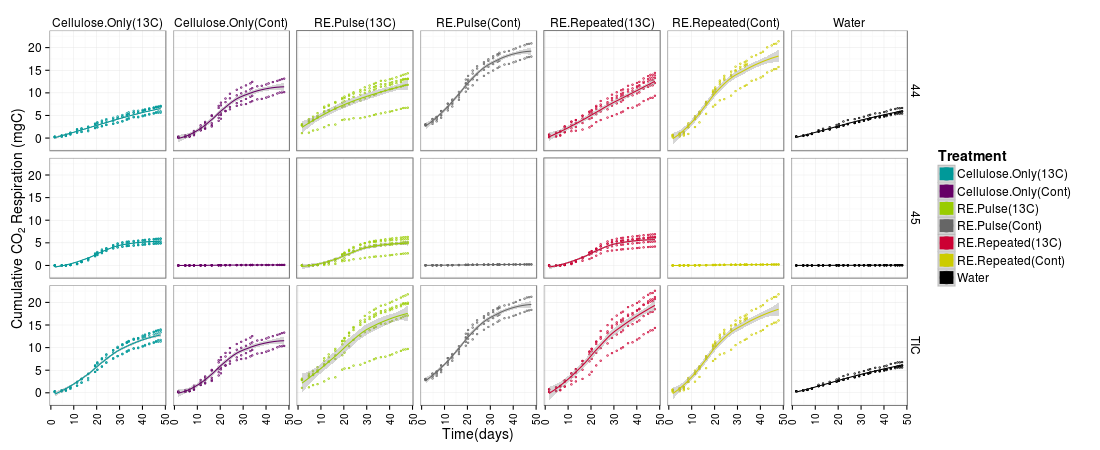

In [12]:
%%R -w 1100 -h 450

colours = c("#009999","#660066","#99CC00", "#666666", "#CC0033","#CCCC00",  "black")

p = ggplot(d, aes(x = Time.days, y = CO2.mgC.cum, group = Flask, color = Treatment))

p = p  + facet_grid(m.z ~ Treatment)

p = p + geom_point(size = 0.75, shape = 21)

p = p + stat_smooth(method = "loess", aes(group = 1))

p = p + theme_bw()

p = p + labs(x = "Time(days)",
             y = expression(paste("Cumulative ", CO[2]," Respiration (mgC)",sep="")))

p = p + theme(strip.background = element_blank(),
              strip.text = element_text(size = 12),
              axis.text.y = element_text(size = 12), 
              axis.text.x = element_text(size = 10, angle = 90, hjust = 0, vjust = 0.5),
              axis.title = element_text(size = 14),
              legend.title = element_text(size = 14),
              legend.text = element_text(size = 12))

p = p + theme(panel.margin = unit(0.5, "lines"))

p = p + scale_color_manual(values = colours)#,
                            #breaks=c("12C100", "12C700", "12C_Control", "13C100", "13C700", "13C_Control", "H2O"),
                            #labels=c("Control - RE.Continuous", "Control - RE.Pulse", "Control - Cellulose.Only",
                            #         "13C - RE.Continuous", "13C - RE.Pulse", "13C - Cellulose.Only", "Water"))
p = p + guides(color = guide_legend(override.aes = list(size = 6)))
#p = p + scale_color_brewer(palette="Dark2")

p

In [13]:
%%R 
pdf("figs/Cum.gas.pdf", width = 15, height = 5)
grid.arrange(p, ncol=1)
dev.off()

png 
  2 


In [14]:
FileLink("figs/Cum.gas.pdf")

/home/ashley/priming_exp/figs/Cum.gas.pdf

In [15]:
%%R 
png("figs/Cum.gas.png", width = 15, height = 5, units = "in", res = 600)
grid.arrange(p, ncol = 1)
dev.off()

png 
  2 


In [16]:
FileLink("figs/Cum.gas.png")

/home/ashley/priming_exp/figs/Cum.gas.png

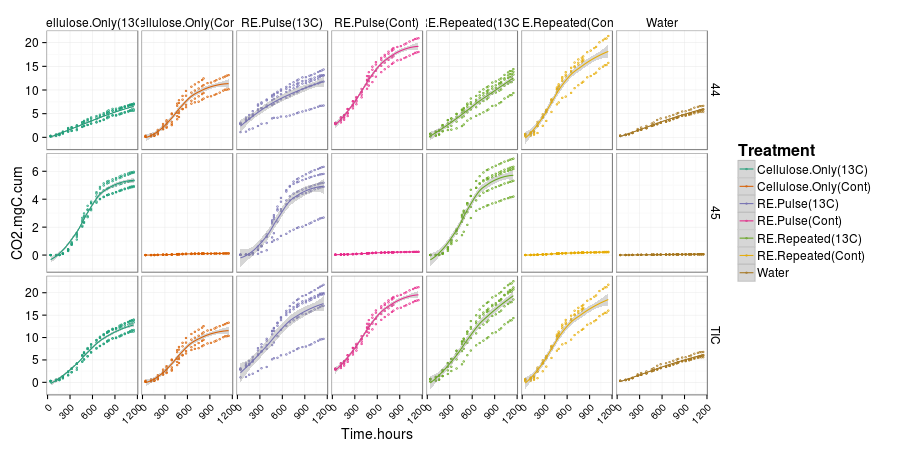

In [17]:
%%R -w 900 -h 450

p = ggplot(d, aes(x = Time.hours, y = CO2.mgC.cum, group = Flask, color = Treatment))

p = p  + facet_grid(m.z ~ Treatment, scales = "free_y")

p = p + geom_point(size = 0.75, shape = 21)

p = p + stat_smooth(method = "loess", aes(group = 1))

p = p + theme_bw()

p = p + theme(strip.background = element_blank(),
              strip.text = element_text(size = 12),
              axis.text.y = element_text(size = 12), 
              axis.text.x = element_text(size = 10, angle = 45, hjust = 1),
              axis.title = element_text(size = 14),
              legend.title = element_text(size = 16),
              legend.text = element_text(size = 12))

p = p + scale_color_brewer(palette="Dark2")

p

In [18]:
%%R
head(rdf_gas)

  Time.hours Time.days Treatment Flask   CO2.ppm m.z   CO2.mgC
0       41.0  1.708333    12C100     1  211.6510  44 0.2347058
1      114.0  4.750000    12C100     1  110.1771  44 0.1221785
2      157.5  6.562500    12C100     1  190.9587  44 0.2117596
3      204.5  8.520833    12C100     1  312.5351  44 0.3465790
4      274.5 11.437500    12C100     1 1374.7648  44 1.5245159
5      321.5 13.395833    12C100     1  930.4757  44 1.0318311


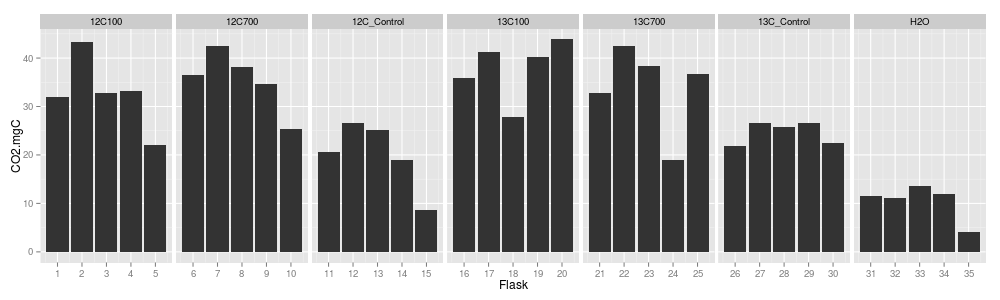

In [19]:
%%R -w 1000 -h 300
p = ggplot(rdf_gas, aes(x = Flask, y = CO2.mgC))

p = p + facet_wrap(~Treatment, scales = "free_x", nrow = 1)
p = p + geom_bar(stat = "identity")

p

In [20]:
%%R
d2 = rdf_gas %>%
    na.omit() %>%
    group_by(Flask, m.z, Treatment) %>%
    summarize(S = sum(CO2.mgC))
d2

Source: local data frame [104 x 4]
Groups: Flask, m.z

   Flask m.z Treatment          S
1      1  44    12C100 15.7280489
2      1  45    12C100  0.2012823
3      1 TIC    12C100 16.0072902
4      2  44    12C100 21.4041047
5      2  45    12C100  0.2278598
6      2 TIC    12C100 21.7899434
7      3  44    12C100 16.1687013
8      3  45    12C100  0.1690115
9      3 TIC    12C100 16.3637460
10     4  44    12C100 16.4545049
..   ... ...       ...        ...


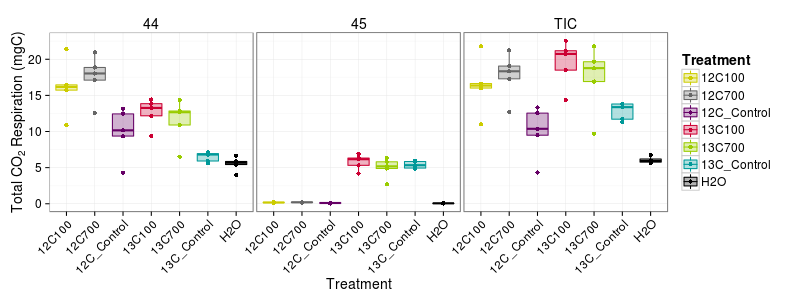

In [21]:
%%R -w 800 -h 300

colours = c("#CCCC00", "#666666", "#660066", "#CC0033", "#99CC00", "#009999", "black")

p = ggplot(d2, aes(x = Treatment, y = S, color = Treatment, fill = Treatment))

p = p + facet_wrap(~m.z)

p = p + geom_boxplot(alpha = 0.3)

p = p + geom_point()

p = p + theme_bw()

p = p + scale_color_manual(values = colours)

p = p + scale_fill_manual(values = colours)

p = p + labs(y = expression(paste("Total ", CO[2], " Respiration (mgC)",sep="")))

p = p + theme(axis.text.x = element_text(size = 12, angle = 45, hjust = 1),
              axis.text.y = element_text(size = 12), 
              axis.title = element_text(size = 14),
              strip.background = element_blank(), 
              strip.text = element_text(size = 14),
              legend.title = element_text(size = 14),
              legend.text = element_text(size = 12))

p

In [22]:
%%R 
pdf("figs/total.gas.pdf", width = 9, height = 4)
grid.arrange(p, ncol=1)
dev.off()

png 
  2 


In [23]:
FileLink("figs/total.gas.pdf")

/home/ashley/priming_exp/figs/total.gas.pdf

In [24]:
%%R 
png("figs/total.gas.png", width = 9, height = 4, units = "in", res = 600)
grid.arrange(p, ncol = 1)
dev.off()

png 
  2 


In [25]:
FileLink("figs/total.gas.png")

/home/ashley/priming_exp/figs/total.gas.png

In [26]:
%%R
print(d)

Source: local data frame [2,244 x 8]
Groups: Flask, m.z, Treatment

   Time.hours Time.days         Treatment Flask   CO2.ppm m.z   CO2.mgC
1        41.0  1.708333 RE.Repeated(Cont)     1  211.6510  44 0.2347058
2       114.0  4.750000 RE.Repeated(Cont)     1  110.1771  44 0.1221785
3       157.5  6.562500 RE.Repeated(Cont)     1  190.9587  44 0.2117596
4       204.5  8.520833 RE.Repeated(Cont)     1  312.5351  44 0.3465790
5       274.5 11.437500 RE.Repeated(Cont)     1 1374.7648  44 1.5245159
6       321.5 13.395833 RE.Repeated(Cont)     1  930.4757  44 1.0318311
7       391.0 16.291667 RE.Repeated(Cont)     1 1717.2775  44 1.9043381
8       463.5 19.312500 RE.Repeated(Cont)     1 1432.4708  44 1.5885078
9       487.0 20.291667 RE.Repeated(Cont)     1  360.5696  44 0.3998459
10      535.0 22.291667 RE.Repeated(Cont)     1  885.9140  44 0.9824153
..        ...       ...               ...   ...       ... ...       ...
Variables not shown: CO2.mgC.cum (dbl)


In [27]:
%%R
d.ave = d %>%
    na.omit() %>%
    group_by(Time.hours, Treatment, m.z) %>%
    summarize(CO2.mgC.cum.ave = mean(CO2.mgC.cum), CO2.mgC.cum.sd = sd(CO2.mgC.cum))

print(d.ave)

Source: local data frame [524 x 5]
Groups: Time.hours, Treatment

   Time.hours            Treatment m.z CO2.mgC.cum.ave CO2.mgC.cum.sd
1          41  Cellulose.Only(13C)  44     0.255094615   0.0782127816
2          41  Cellulose.Only(13C)  45     0.002691405   0.0008103027
3          41  Cellulose.Only(13C) TIC     0.260190373   0.0789529061
4          41 Cellulose.Only(Cont)  44     0.196428792   0.1002521963
5          41 Cellulose.Only(Cont)  45     0.002051655   0.0010637520
6          41 Cellulose.Only(Cont) TIC     0.198233637   0.0994974297
7          41        RE.Pulse(13C)  44     2.548914042   0.8177971657
8          41        RE.Pulse(13C)  45     0.026312753   0.0084485288
9          41        RE.Pulse(13C) TIC     2.573218296   0.8259892349
10         41       RE.Pulse(Cont)  44     2.943999992   0.1152266077
..        ...                  ... ...             ...            ...


In [28]:
%%R
write.table(d.ave, 
            file = "data/gas_cum_ave.csv",
            row.names = FALSE,
            sep = ",")

In [29]:
%%R
#Select for Time til 50% of 13C-cellulose used for each flask/treatment
d.50pct = d %>%
    filter((m.z == "45") & (CO2.mgC.cum < 4.5)) %>%
    summarize(Time = max(Time.hours)) %>%
    filter(Treatment %in% c("13C100", "13C_Control", "13C700"))
d.50pct

Source: local data frame [0 x 4]
Groups: Flask, m.z

Variables not shown: Flask (int), m.z (fctr), Treatment (chr), Time (dbl)


In [30]:
%%R
fit = lm(Time~Treatment, data = d.50pct)
#aov(Time~Treatment, data = d.50pct)
summary(fit)

Error in `contrasts<-`(`*tmp*`, value = contr.funs[1 + isOF[nn]]) : 
  contrasts can be applied only to factors with 2 or more levels
In addition: Warning messages:
1: Removed 2 rows containing missing values (position_stack). 
2: Removed 1 rows containing missing values (position_stack). 
3: Removed 1 rows containing missing values (position_stack). 
4: Removed 8 rows containing missing values (position_stack). 
5: Removed 7 rows containing missing values (position_stack). 
6: Removed 41 rows containing missing values (position_stack).
Error in `contrasts<-`(`*tmp*`, value = contr.funs[1 + isOF[nn]]) : 
  contrasts can be applied only to factors with 2 or more levels


In [31]:
%%R
anova(fit)

Error in anova(fit) : object 'fit' not found


In [32]:
%%R
c = subset(d.ave, (Time.hours == "1150") & (m.z == "45"))
print(c)

Source: local data frame [7 x 5]
Groups: Time.hours, Treatment

  Time.hours            Treatment m.z CO2.mgC.cum.ave CO2.mgC.cum.sd
1       1150  Cellulose.Only(13C)  45      5.53563092    0.484766046
2       1150 Cellulose.Only(Cont)  45      0.12078568    0.020384193
3       1150        RE.Pulse(13C)  45      4.97606614    1.394910433
4       1150       RE.Pulse(Cont)  45      0.23176617    0.001236512
5       1150     RE.Repeated(13C)  45      5.77952009    1.054432608
6       1150    RE.Repeated(Cont)  45      0.21888415    0.024892832
7       1150                Water  45      0.06557306    0.008237299


Error : Mapping a variable to y and also using stat="bin".
  With stat="bin", it will attempt to set the y value to the count of cases in each group.
  This can result in unexpected behavior and will not be allowed in a future version of ggplot2.
  If you want y to represent counts of cases, use stat="bin" and don't map a variable to y.
  If you want y to represent values in the data, use stat="identity".
  See ?geom_bar for examples. (Defunct; last used in version 0.9.2)


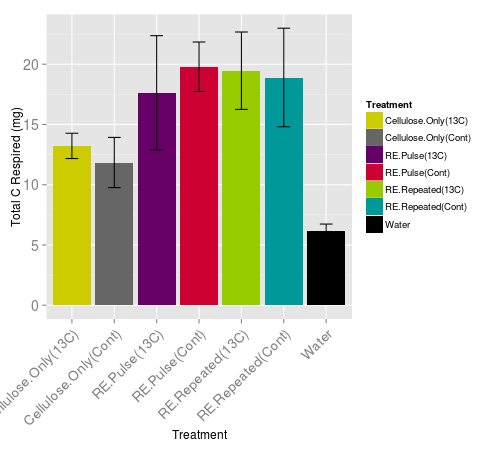

In [33]:
%%R -w 500 -h 450
c = subset(d.ave, (Time.hours == "1150") & (m.z == "TIC"))
limits <- aes(ymax = CO2.mgC.cum.ave + CO2.mgC.cum.sd, ymin= CO2.mgC.cum.ave - CO2.mgC.cum.sd)

colours = c("#CCCC00", "#666666", "#660066", "#CC0033", "#99CC00", "#009999", "black")

p2 = ggplot(c, aes(x = Treatment, y = CO2.mgC.cum.ave, fill=Treatment))

p2 = p2 + geom_bar(stat="identity")

p2 = p2 + scale_fill_manual(values = colours)

p2 = p2 + labs(x = "Treatment", y = "Total C Respired (mg)")

p2 = p2 + theme(axis.text.x = element_text(size = 14, angle = 45, hjust = 1),
              axis.text.y = element_text(size = 14))

dodge <- position_dodge(width=0.9)
p2 = p2 + geom_bar(position=dodge) + geom_errorbar(limits, position=dodge, width=0.3)

p2

Error : Mapping a variable to y and also using stat="bin".
  With stat="bin", it will attempt to set the y value to the count of cases in each group.
  This can result in unexpected behavior and will not be allowed in a future version of ggplot2.
  If you want y to represent counts of cases, use stat="bin" and don't map a variable to y.
  If you want y to represent values in the data, use stat="identity".
  See ?geom_bar for examples. (Defunct; last used in version 0.9.2)


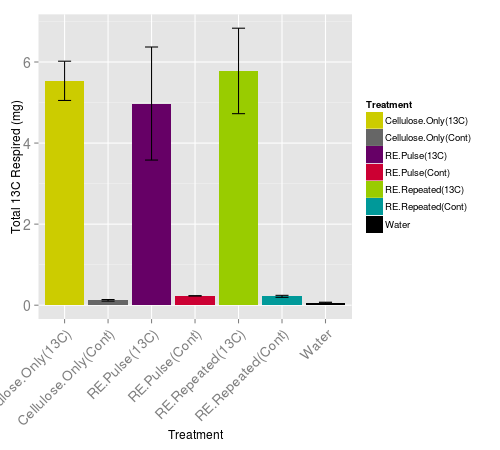

In [34]:
%%R -w 500 -h 450
c = subset(d.ave, (Time.hours == "1150") & (m.z == "45"))
limits <- aes(ymax = CO2.mgC.cum.ave + CO2.mgC.cum.sd, ymin= CO2.mgC.cum.ave - CO2.mgC.cum.sd)

colours = c("#CCCC00", "#666666", "#660066", "#CC0033", "#99CC00", "#009999", "black")

p2 = ggplot(c, aes(x = Treatment, y = CO2.mgC.cum.ave, fill=Treatment))

p2 = p2 + geom_bar(stat="identity")

p2 = p2 + scale_fill_manual(values = colours)

p2 = p2 + labs(x = "Treatment", y = "Total 13C Respired (mg)")

p2 = p2 + theme(axis.text.x = element_text(size = 14, angle = 45, hjust = 1),
              axis.text.y = element_text(size = 14))

dodge <- position_dodge(width=0.9)
p2 = p2 + geom_bar(position=dodge) + geom_errorbar(limits, position=dodge, width=0.3)

p2

Error : Mapping a variable to y and also using stat="bin".
  With stat="bin", it will attempt to set the y value to the count of cases in each group.
  This can result in unexpected behavior and will not be allowed in a future version of ggplot2.
  If you want y to represent counts of cases, use stat="bin" and don't map a variable to y.
  If you want y to represent values in the data, use stat="identity".
  See ?geom_bar for examples. (Defunct; last used in version 0.9.2)


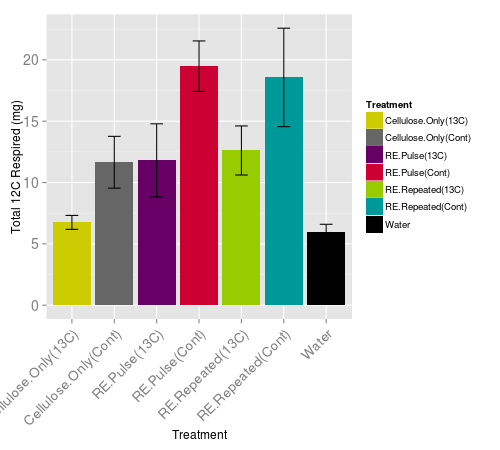

In [35]:
%%R -w 500 -h 450
c = subset(d.ave, (Time.hours == "1150") & (m.z == "44"))
limits <- aes(ymax = CO2.mgC.cum.ave + CO2.mgC.cum.sd, ymin= CO2.mgC.cum.ave - CO2.mgC.cum.sd)

colours = c("#CCCC00", "#666666", "#660066", "#CC0033", "#99CC00", "#009999", "black")

p2 = ggplot(c, aes(x = Treatment, y = CO2.mgC.cum.ave, fill=Treatment))

p2 = p2 + geom_bar(stat="identity")

p2 = p2 + scale_fill_manual(values = colours)

p2 = p2 + labs(x = "Treatment", y = "Total 12C Respired (mg)")

p2 = p2 + theme(axis.text.x = element_text(size = 14, angle = 45, hjust = 1),
              axis.text.y = element_text(size = 14))

dodge <- position_dodge(width=0.9)
p2 = p2 + geom_bar(position=dodge) + geom_errorbar(limits, position=dodge, width=0.3)

p2

In [36]:
%%R

rate = d %>%
    na.omit() %>%
    group_by(Time.days, Treatment, m.z) %>%
    summarize(CO2.mgC.ave = mean(CO2.mgC), CO2.mgC.sd = sd(CO2.mgC)) %>%
    mutate(rate=CO2.mgC.ave/Time.days)

print(rate)

Source: local data frame [524 x 6]
Groups: Time.days, Treatment

   Time.days            Treatment m.z CO2.mgC.ave   CO2.mgC.sd        rate
1   1.708333  Cellulose.Only(13C)  44 0.255094615 0.0782127816 0.149323677
2   1.708333  Cellulose.Only(13C)  45 0.002691405 0.0008103027 0.001575457
3   1.708333  Cellulose.Only(13C) TIC 0.260190373 0.0789529061 0.152306560
4   1.708333 Cellulose.Only(Cont)  44 0.196428792 0.1002521963 0.114982707
5   1.708333 Cellulose.Only(Cont)  45 0.002051655 0.0010637520 0.001200969
6   1.708333 Cellulose.Only(Cont) TIC 0.198233637 0.0994974297 0.116039202
7   1.708333        RE.Pulse(13C)  44 2.548914042 0.8177971657 1.492047244
8   1.708333        RE.Pulse(13C)  45 0.026312753 0.0084485288 0.015402587
9   1.708333        RE.Pulse(13C) TIC 2.573218296 0.8259892349 1.506274125
10  1.708333       RE.Pulse(Cont)  44 2.943999992 0.1152266077 1.723317069
..       ...                  ... ...         ...          ...         ...


In [45]:
%%R
write.table(rate, 
            file = "data/gas_daily_rate.csv",
            row.names = FALSE,
            sep = ",")

In [37]:
%%R
rate.45 = subset(rate, (m.z == "45")) #& 
                 #(Treatment %in% c("Cellulose.Only(13C)", "RE.Continuous(13C)", "RE.Pulse(13C)")))
rate.45

Source: local data frame [174 x 6]
Groups: Time.days, Treatment

   Time.days            Treatment m.z CO2.mgC.ave   CO2.mgC.sd         rate
1   1.708333  Cellulose.Only(13C)  45 0.002691405 0.0008103027 0.0015754567
2   1.708333 Cellulose.Only(Cont)  45 0.002051655 0.0010637520 0.0012009690
3   1.708333        RE.Pulse(13C)  45 0.026312753 0.0084485288 0.0154025868
4   1.708333       RE.Pulse(Cont)  45 0.030323479 0.0011825826 0.0177503291
5   1.708333     RE.Repeated(13C)  45 0.005421521 0.0031154083 0.0031735731
6   1.708333    RE.Repeated(Cont)  45 0.005390566 0.0021330476 0.0031554533
7   1.708333                Water  45 0.003551075 0.0001983204 0.0020786780
8   4.750000  Cellulose.Only(13C)  45 0.002180103 0.0005511735 0.0004589690
9   4.750000 Cellulose.Only(Cont)  45 0.001528884 0.0008025520 0.0003218704
10  4.750000        RE.Pulse(13C)  45 0.007407279 0.0045742237 0.0015594272
..       ...                  ... ...         ...          ...          ...


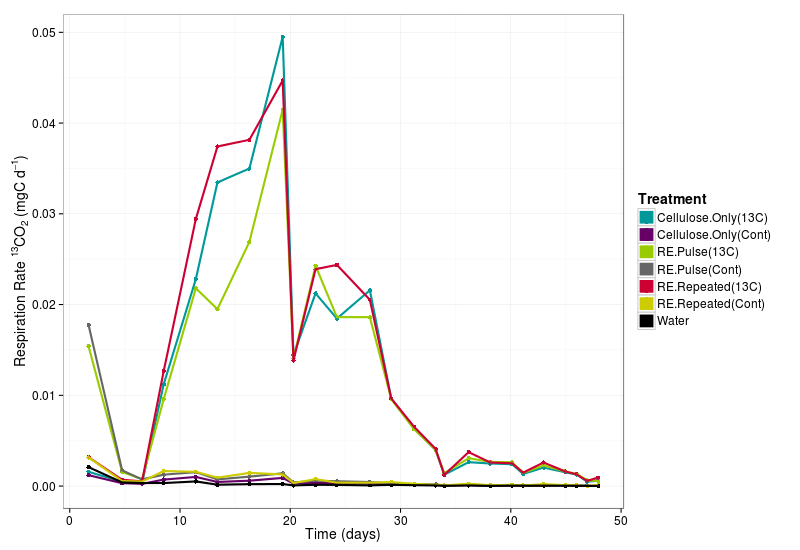

In [38]:
%%R -w 800 -h 550

colours = c("#009999","#660066","#99CC00", "#666666", "#CC0033","#CCCC00",  "black")

#limits <- aes(ymax = CO2.mgC.cum.ave + CO2.mgC.cum.sd, ymin= CO2.mgC.cum.ave - CO2.mgC.cum.sd)

p = ggplot(rate.45, aes(x = Time.days, y = rate, color = Treatment)) 

p = p + geom_point() 

p = p + geom_line(size = 1) 

p = p + labs(x = "Time (days)", 
             y = expression(paste("Respiration Rate ", {}^13, "C",O[2], " (mgC d", {}^-1, ")", sep="")))

p = p + scale_color_manual(values = colours)

p = p + theme_bw()

p = p + theme(axis.text.x = element_text(size = 12),
              axis.text.y = element_text(size = 12), 
              axis.title = element_text(size = 14),
              legend.title = element_text(size = 14),
              legend.text = element_text(size = 12))

p = p + guides(color = guide_legend(override.aes = list(size = 6)))

#dodge <- position_dodge(width=0.9)
#p = p + geom_bar(position=dodge) + geom_errorbar(limits, position=dodge, width=0.3)

#p = p + scale_y_l
#geom_linerange(aes(x=date.time, ymin=ymin_C__mg, ymax=ymax_C__mg)) 

p

In [39]:
%%R 
pdf("figs/13C.daily.rate.pdf", width = 9, height = 6)
grid.arrange(p, ncol=1)
dev.off()

png 
  2 


In [40]:
FileLink("figs/13C.daily.rate.pdf")

/home/ashley/priming_exp/figs/13C.daily.rate.pdf

In [41]:
%%R 
png("figs/13C.daily.rate.png", width = 9, height = 6, units = "in", res = 600)
grid.arrange(p, ncol = 1)
dev.off()

png 
  2 


In [42]:
FileLink("figs/13C.daily.rate.png")

/home/ashley/priming_exp/figs/13C.daily.rate.png

In [43]:
%%R
rate.TIC = subset(rate, (m.z == "TIC"))
rate.TIC

Source: local data frame [175 x 6]
Groups: Time.days, Treatment

   Time.days            Treatment m.z CO2.mgC.ave CO2.mgC.sd       rate
1   1.708333  Cellulose.Only(13C) TIC   0.2601904 0.07895291 0.15230656
2   1.708333 Cellulose.Only(Cont) TIC   0.1982336 0.09949743 0.11603920
3   1.708333        RE.Pulse(13C) TIC   2.5732183 0.82598923 1.50627412
4   1.708333       RE.Pulse(Cont) TIC   2.9727532 0.11484068 1.74014824
5   1.708333     RE.Repeated(13C) TIC   0.5345113 0.30044741 0.31288469
6   1.708333    RE.Repeated(Cont) TIC   0.5261542 0.20468010 0.30799272
7   1.708333                Water TIC   0.3406411 0.02600648 0.19939967
8   4.750000  Cellulose.Only(13C) TIC   0.2195007 0.05409709 0.04621067
9   4.750000 Cellulose.Only(Cont) TIC   0.1493090 0.07230101 0.03143346
10  4.750000        RE.Pulse(13C) TIC   0.7209021 0.44510015 0.15176886
..       ...                  ... ...         ...        ...        ...


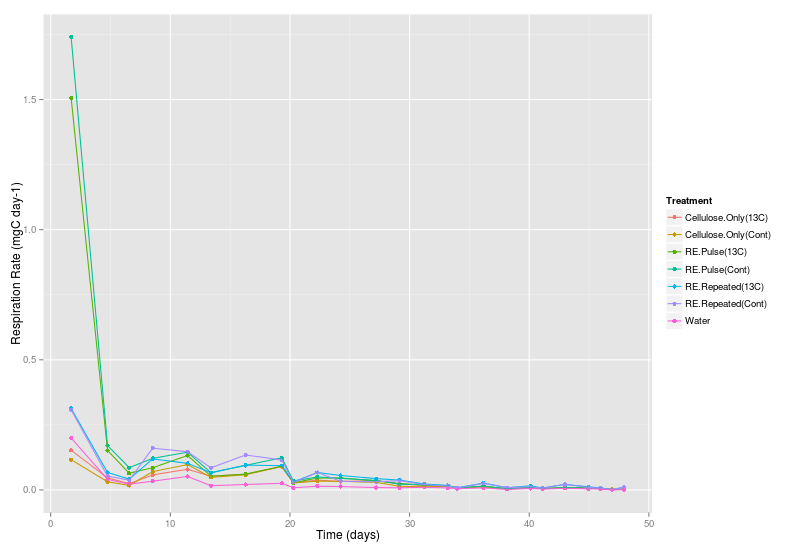

In [44]:
%%R -w 800 -h 550

#limits <- aes(ymax = CO2.mgC.cum.ave + CO2.mgC.cum.sd, ymin= CO2.mgC.cum.ave - CO2.mgC.cum.sd)

p = ggplot(rate.TIC, aes(x = Time.days, y = rate, color = Treatment)) 

p = p + geom_point() 

p = p + geom_line() 

p = p + labs(x = "Time (days)", y = "Respiration Rate (mgC day-1)")

#dodge <- position_dodge(width=0.9)
#p = p + geom_bar(position=dodge) + geom_errorbar(limits, position=dodge, width=0.3)

#p = p + scale_y_l
#geom_linerange(aes(x=date.time, ymin=ymin_C__mg, ymax=ymax_C__mg)) 

p